In [1]:
!pip install xgboost
!pip install sklearn
!pip install Keras
!pip install tensorflow

You should consider upgrading via the '/Users/chris/opt/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/chris/opt/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/chris/opt/miniconda3/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/Users/chris/opt/miniconda3/bin/python -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import precision_score, make_scorer, log_loss, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

%reload_ext autoreload
%autoreload 1
%aimport utils

og_data = pd.read_csv('data.csv', parse_dates=['game_date'])
utils.engineer_features_and_write_file(og_data)
og_data = pd.read_csv('data_engineered.csv', parse_dates=['game_date'])
og_data = og_data.sort_values(by="game_event_id")

In [4]:
#feature engineering
#data parsing
og_data.seconds_remaining = pd.to_timedelta(og_data.seconds_remaining, unit='s')
og_data.minutes_remaining = pd.to_timedelta(og_data.minutes_remaining, unit='m')
og_data['time_remaining'] = og_data.minutes_remaining+og_data.seconds_remaining

#binning of time_remaining
time_remaining_bins_labels = [[
    pd.Timedelta(minutes = 0),
    pd.Timedelta(minutes = 5),
    pd.Timedelta(minutes = 10),
    pd.Timedelta(minutes = 20)
], ['0-5min', '5-10min', '10-20min']]

og_data['time_remaining_label'] = pd.cut(og_data['time_remaining'], time_remaining_bins_labels[0], labels = time_remaining_bins_labels[1])
og_data['time_remaining_label2']=og_data['time_remaining_label'].astype('category').cat.codes

# Handle dates
og_data["game_year"] = og_data["game_date"].dt.year
og_data["game_month"] = og_data["game_date"].dt.month
og_data["game_day"] = og_data["game_date"].dt.day

# Calculate shot efficiency per month
efficiency_by_month = (og_data.groupby(['game_year', 'game_month'], dropna=True)["shot_made_flag"].sum() 
                       / og_data.groupby(['game_year', 'game_month'], dropna=True)["shot_made_flag"].count()
                      ).shift(1, fill_value=0.4400971254369479)

og_data = og_data.join(efficiency_by_month, on=['game_year', 'game_month'], how='left', lsuffix='', rsuffix='_pct')

#use only if data needs to be regenerated
utils.engineer_features_and_write_file(og_data)

#there are 5000 shot_made_flag null values, that's our test data, the rest is training data
test = og_data.loc[og_data['shot_made_flag'].isnull()]
data = og_data.loc[og_data['shot_made_flag'].notnull()]

feature_switch = {
    'distance_traveled': 1,
    'two_pt_attempted' : 1,
    'three_pt_attempted': 1,
    'pts_attempted': 0,
    'right_of_net': 0,
    'shot_distance': 1,
    'period': 1,
    'home_game': 1,
    'shot_zone_area2': 0,
    'playoffs': 0,
    'time_remaining_label2': 1,
    'action_type2': 1,
    'combined_shot_type2': 1,
    'opponent2': 1,
    'game_year': 1,
    'game_month': 0,
    'game_day': 0,
    'angle': 1,
    'shot_made_flag_pct': 1,
}

chosen_features = [key for key, value in feature_switch.items() if value == 1]

data.columns


Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id',
       'two_pt_attempted', 'three_pt_attempted', 'pts_attempted',
       'action_type2', 'combined_shot_type2', 'opponent2', 'home_game',
       'shot_zone_area2', 'angle', 'distance', 'distance_traveled',
       'right_of_net', 'time_remaining', 'time_remaining_label',
       'time_remaining_label2', 'game_year', 'game_month', 'game_day',
       'shot_made_flag_pct'],
      dtype='object')

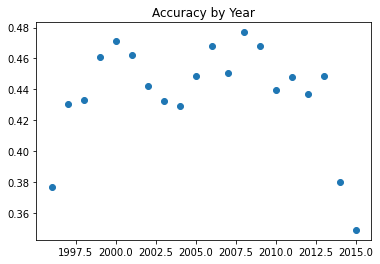

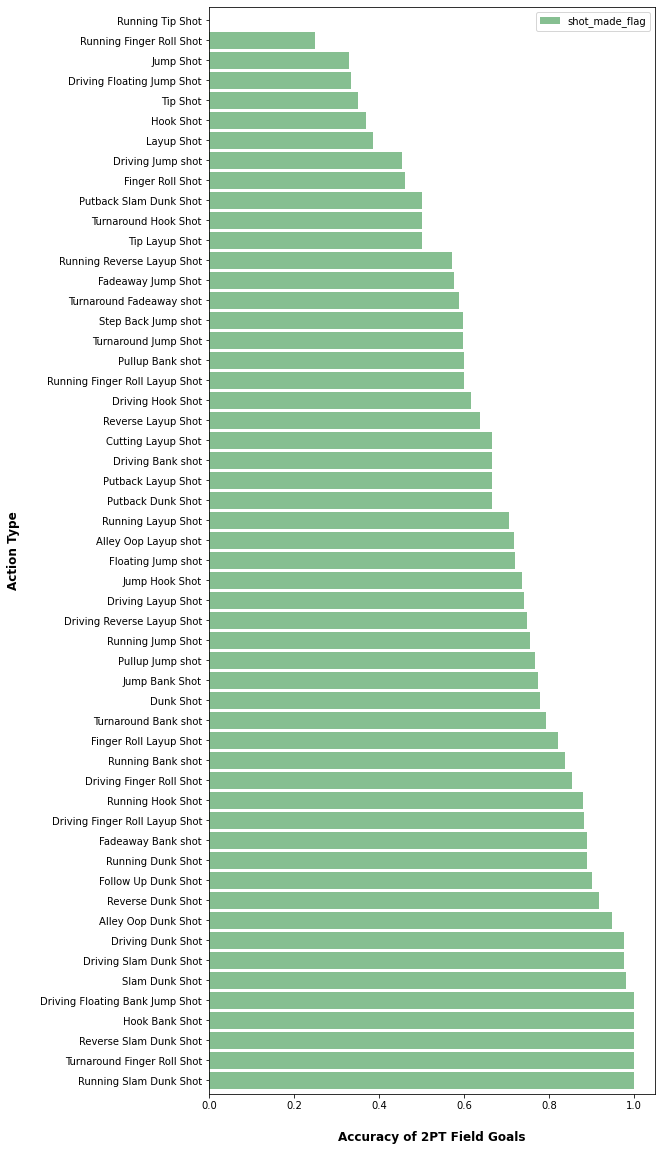

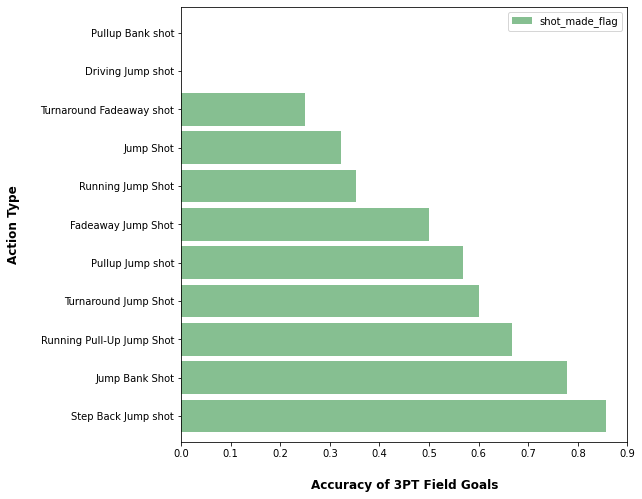

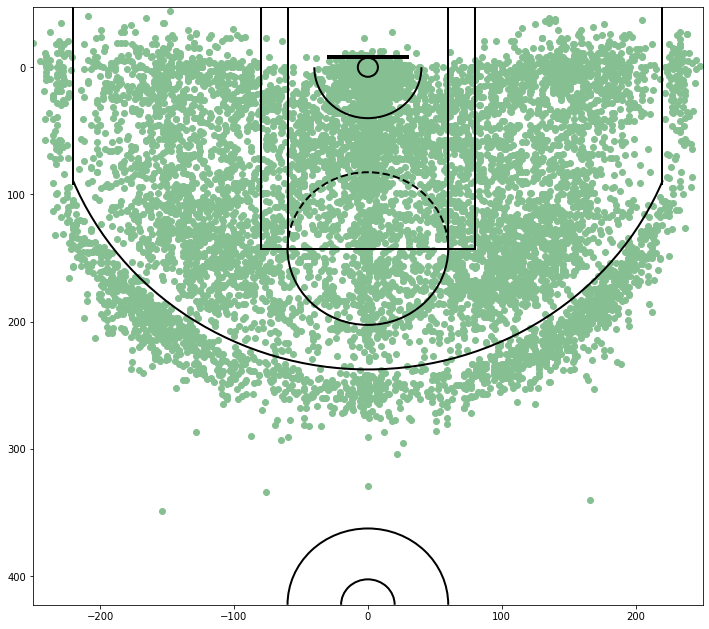

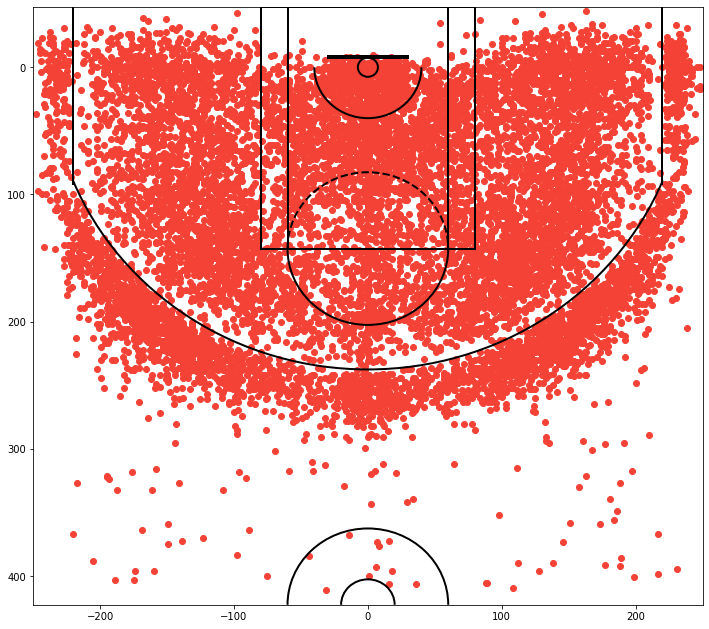

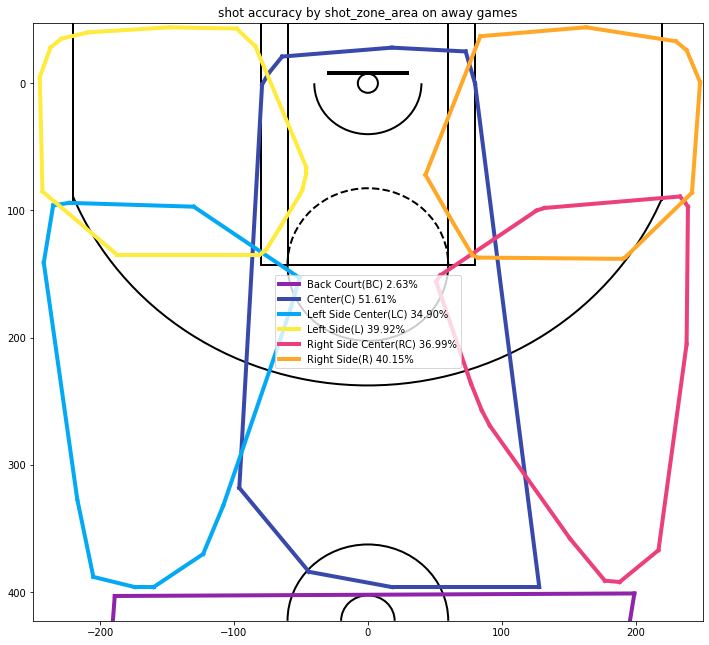

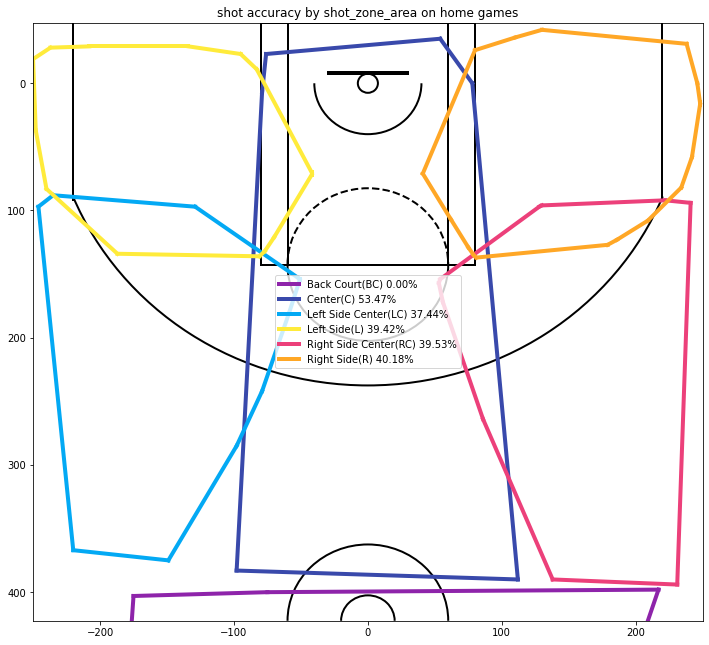

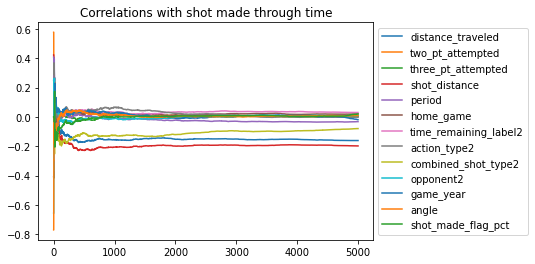

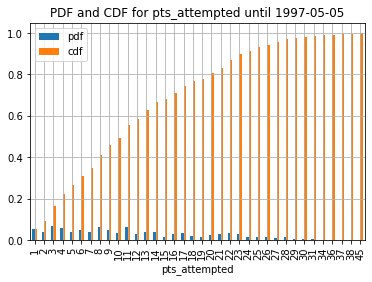

In [4]:
utils.draw_exploratory_data_charts(data, test, chosen_features)

/Users/chris/OneDrive - Knights - University of Central Florida/Machine Learning/CAP5610FinalProject/Project/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cluster"] = labels


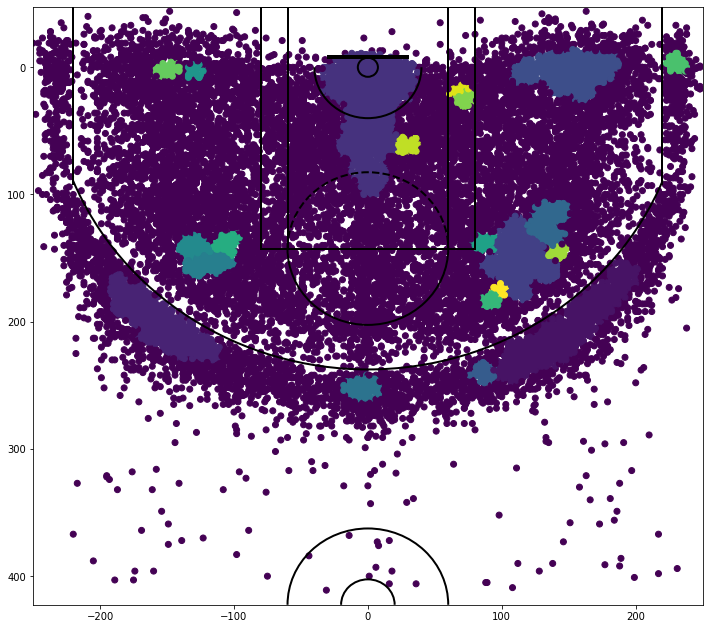

In [5]:
utils.db_scan(data)

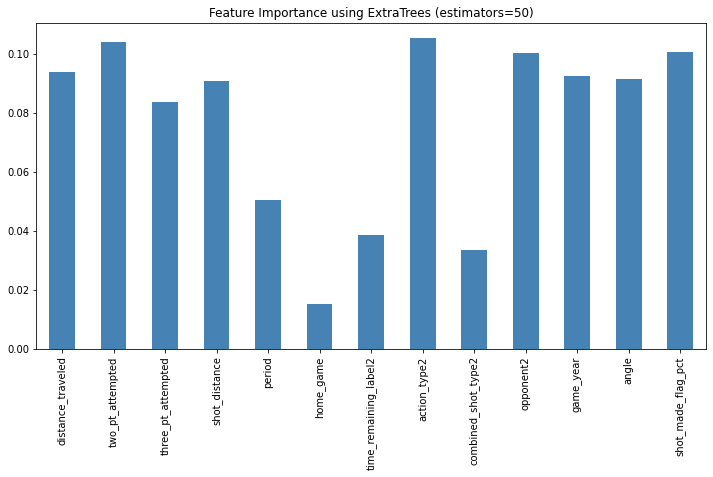

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

y = data['shot_made_flag']
X = data[chosen_features]

# print(X.shape)

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
# print(X_new.shape)

pd.Series(clf.feature_importances_, index=chosen_features).plot.bar(color='steelblue', figsize=(12, 6), title='Feature Importance using ExtraTrees (estimators=50)');

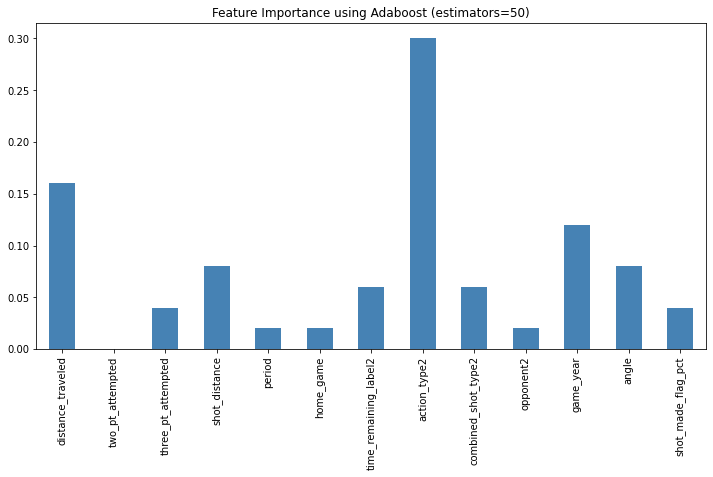

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel

y = data['shot_made_flag']
X = data[chosen_features]

# print(X.shape)

clf = AdaBoostClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
# print(X_new.shape)

pd.Series(clf.feature_importances_, index=chosen_features).plot.bar(color='steelblue', figsize=(12, 6), title='Feature Importance using Adaboost (estimators=50)');

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

y = data['shot_made_flag']
X = data[chosen_features]

# print(X.shape)

clf = GradientBoostingClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

pd.Series(clf.feature_importances_, index=chosen_features).plot.bar(color='steelblue', figsize=(12, 6), title='Feature Importance using Gradient Boosting (estimators=50)');

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

y = data['shot_made_flag']
X = data[chosen_features]

# print(X.shape)

clf = RandomForestClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

pd.Series(clf.feature_importances_, index=chosen_features).plot.bar(color='steelblue', figsize=(12, 6), title='Feature Importance using Random Forest (estimators=50)');

In [ ]:
X = data[chosen_features]
y = data['shot_made_flag']
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

print("Five-fold cross validation on Gradient Boosting: ")
gradient = GradientBoostingClassifier(n_estimators=100, max_depth=4)

score = cross_val_score(gradient, X, y, cv=5)
print(sum(score) / len(score))

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

print("Five-fold cross validation on Random Forest: ")

rf = RandomForestClassifier(n_estimators=200, max_depth=8)

score = cross_val_score(rf, X, y, cv=5)
print(sum(score) / len(score))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

print("Five-fold cross validation on AdaBoost: ")
adaBoost = AdaBoostClassifier(n_estimators=100, random_state=0)

score = cross_val_score(adaBoost, X, y, cv=5)
print(sum(score) / len(score))

In [ ]:
# tscv = TimeSeriesSplit()
# params = {
#     "loss":["deviance"],
#     "learning_rate":[0.01, 0.025, 0.05, 0.075, 0.1, 0.2],
#     "n_estimators":[10, 50, 100, 200, 300, 400, 500, 600],
#     "subsample":[0.5, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
#     "criterion":['friedman_mse', 'mae'],
#     "max_depth":[3, 4, 5, 8],
#     "max_features":["sqrt", "log2"],
#     "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 12)
# }
# clf = GridSearchCV(GradientBoostingClassifier(), params, cv=tscv)
# clf.fit(X, y)
# print(clf.score(X, y))
# print(clf.best_params_)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
print("Five-fold cross validation on XGBoost: ")

clf = xgb.XGBClassifier(colsample_bytree= 0.7, learning_rate= 0.04, max_depth= 4, min_child_weight= 10, n_estimators= 1000, objective= 'binary:logistic', seed= 1000, subsample= 0.8)
score = cross_val_score(clf, X, y, cv=5)
print(sum(score) / len(score))

In [ ]:
print("Five-fold Time Series Split on XGBoost: ")
clfxgb = xgb.XGBClassifier(colsample_bytree= 0.7, learning_rate= 0.04, max_depth= 4, min_child_weight= 10, n_estimators= 1000, objective= 'binary:logistic', seed= 1000, subsample= 0.8)
score = cross_val_score(clf, X, y, cv=TimeSeriesSplit())
print(sum(score) / len(score))

In [45]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import scipy.stats as stats

parameters = {'objective':['binary:hinge', 'binary:logistic'],
               'learning_rate': stats.uniform(0.04, 1), 
               'max_depth': randint(3, 15),
               'min_child_weight': randint(8, 15),
               'subsample': stats.uniform(0.4, 1),
               'colsample_bytree': stats.uniform(0.5, 1),
               'n_estimators': randint(300, 1500), 
               'seed': [1000]}

clf = RandomizedSearchCV(xgb.XGBClassifier(), parameters, n_iter=100, cv=TimeSeriesSplit(), scoring=['accuracy', 'neg_log_loss'], refit='neg_log_loss', n_jobs=-1, verbose=1)
clf.fit(X, y)
# print(cross_val_score(clf, X, y, scoring='accuracy', cv=TimeSeriesSplit(n_splits=n_splits)))
print(clf.best_params_)
print(clf.best_score_)

## Best Params
# {'colsample_bytree': 0.8633662204129675, 'learning_rate': 0.04606378371089711, 'max_depth': 4, 'min_child_weight': 13, 'n_estimators': 381, 'objective': 'binary:logistic', 'seed': 1000, 'subsample': 0.47585467655185354}

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed: 17.5min remaining:   14.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.6min finished


{'colsample_bytree': 0.8633662204129675, 'learning_rate': 0.04606378371089711, 'max_depth': 4, 'min_child_weight': 13, 'n_estimators': 381, 'objective': 'binary:logistic', 'seed': 1000, 'subsample': 0.47585467655185354}
-0.6092536985206024


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

n_splits = 5
## These were the final best parameters after running a full GridSearch
parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.04], 
              'max_depth': [4],
              'min_child_weight': [12],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000], 
              'seed': [1000]}

#clf = GridSearchCV(xgb.XGBClassifier(), parameters, cv=TimeSeriesSplit(n_splits=5), scoring='accuracy')
#clf.fit(X, y)
#print(cross_val_score(clf, X, y, scoring='accuracy', cv=TimeSeriesSplit(n_splits=n_splits)))

#print(clf.best_params_)

In [17]:
X = data[chosen_features]
y = data['shot_made_flag']
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [29]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint

parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(6, 15),
    'min_samples_split': randint(2, 500),
    'min_samples_leaf': randint(2, 100),
    'n_estimators': randint(100, 500),
    'max_features': [None, 'sqrt']
}

clf = RandomizedSearchCV(RandomForestClassifier(), parameters, n_iter=100, cv=TimeSeriesSplit(), scoring=['accuracy', 'neg_log_loss'], refit='neg_log_loss', n_jobs=-1, verbose=1)
clf.fit(X, y)

print(clf.best_score_)
print(clf.best_params_)

# Best Params
#{'criterion': 'entropy', 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 21, 'min_samples_split': 120, 'n_estimators': 345}

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 26.9min finished


-0.6045454822745404
{'criterion': 'entropy', 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 21, 'min_samples_split': 120, 'n_estimators': 345}


In [ ]:
#print(clf.score(X, y))

In [6]:
n_features = X.shape[1]
def create_dense_nn():
    model = Sequential()
    model.add(Dense(n_features, input_dim=n_features))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [50]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(criterion='entropy', max_features=None, min_samples_leaf=21, min_samples_split=120,
                              n_estimators=345, random_state=1, max_depth=13)
clf3 = GaussianNB()
clf4 = AdaBoostClassifier(base_estimator = clf1)
clf5 = AdaBoostClassifier(base_estimator = RandomForestClassifier(criterion='entropy', n_estimators=2, random_state=1))
clf6 = AdaBoostClassifier(base_estimator = clf3)
clf7 = AdaBoostClassifier(n_estimators=100, random_state=0)
clf8 = ExtraTreesClassifier(n_estimators=50)
clf9 = GradientBoostingClassifier(n_estimators=400, max_depth=4)
clf10 = xgb.XGBClassifier(colsample_bytree= 0.8633662204129675, learning_rate= 0.04606378371089711, max_depth= 4, min_child_weight= 13, n_estimators= 381, objective= 'binary:logistic', seed= 1000, subsample=0.47585467655185354)
eclf = VotingClassifier(
estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('lrada', clf4), ('rfada', clf5), ('gnada', clf6), ('ada', clf7), ('extra', clf8), ('gradient', clf9), ('xgb', clf10)],
voting='soft')
keras = KerasClassifier(build_fn=create_dense_nn, epochs=100, batch_size=10, verbose=0)

seclf = StackingClassifier(estimators=[('rf', clf2), ('ada', clf7), ('gradient', clf9)], final_estimator=RandomForestClassifier(criterion='entropy', n_estimators=2, random_state=1))


In [53]:
final_scores = {'test_accuracy': [], 'test_neg_log_loss': [], 'test_recall': [], 'test_precision': [], 'test_f1': [] , 'labels': []}
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, clf10, eclf, keras, seclf], ['Logistic Regression', 'Random Forest', 'Naïve Bayes', 'Logistic Regression (Ada)', 'Random Forest (Ada)', 'Naïve bayes (Ada)', 'Adaboost', 'ExtraTrees','Gradient Boosting', 'XGB Classifier', 'Ensemble', 'Neural Network', 'Stacking Classifier']):
    scores = cross_validate(clf, X, y, cv=TimeSeriesSplit(), scoring=['neg_log_loss', 'accuracy', 'precision', 'recall', 'f1'])
    print('==============='+label+'=================')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std(), label))
    print("Neg Log Loss: %0.2f (+/- %0.2f) [%s]" % (scores['test_neg_log_loss'].mean(), scores['test_neg_log_loss'].std(), label))
    print("Precision: %0.2f (+/- %0.2f) [%s]" % (scores['test_precision'].mean(), scores['test_precision'].std(), label))
    print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), label))
    print("F1: %0.2f (+/- %0.2f) [%s]" % (scores['test_f1'].mean(), scores['test_f1'].std(), label))
    final_scores['test_accuracy'].append(scores['test_accuracy'])
    final_scores['test_neg_log_loss'].append(scores['test_neg_log_loss'])
    final_scores['test_recall'].append(scores['test_recall'])
    final_scores['test_precision'].append(scores['test_precision'])
    final_scores['test_f1'].append(scores['test_f1'])
    final_scores['labels'].append(label)

===============Logistic Regression=================
Accuracy: 0.60 (+/- 0.01) [Logistic Regression]
Neg Log Loss: -0.66 (+/- 0.01) [Logistic Regression]
Precision: 0.56 (+/- 0.02) [Logistic Regression]
Recall: 0.39 (+/- 0.07) [Logistic Regression]
F1: 0.46 (+/- 0.05) [Logistic Regression]
===============Random Forest=================
Accuracy: 0.69 (+/- 0.01) [Random Forest]
Neg Log Loss: -0.60 (+/- 0.01) [Random Forest]
Precision: 0.72 (+/- 0.01) [Random Forest]
Recall: 0.47 (+/- 0.00) [Random Forest]
F1: 0.57 (+/- 0.00) [Random Forest]
===============Naïve Bayes=================
Accuracy: 0.64 (+/- 0.01) [Naïve Bayes]
Neg Log Loss: -0.83 (+/- 0.01) [Naïve Bayes]
Precision: 0.63 (+/- 0.02) [Naïve Bayes]
Recall: 0.44 (+/- 0.01) [Naïve Bayes]
F1: 0.52 (+/- 0.01) [Naïve Bayes]
===============Logistic Regression (Ada)=================
Accuracy: 0.59 (+/- 0.01) [Logistic Regression (Ada)]
Neg Log Loss: -0.69 (+/- 0.00) [Logistic Regression (Ada)]
Precision: 0.55 (+/- 0.01) [Logistic Regres

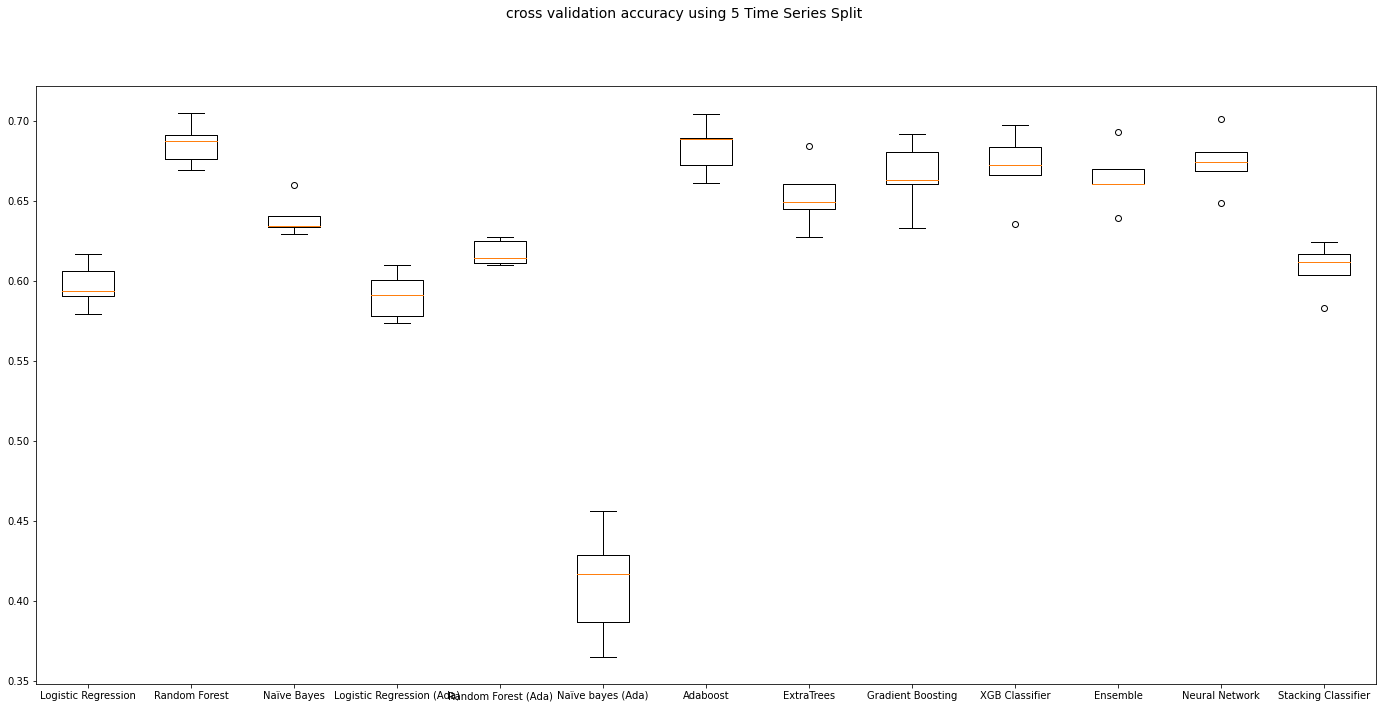

In [17]:
fig = plt.figure(figsize=(24, 11))
fig.suptitle('cross validation accuracy using ' + str(5) + ' Time Series Split', fontsize=14)
ax = fig.add_subplot(111)
plt.boxplot(final_scores['test_accuracy'])
ax.set_xticklabels(final_scores['labels'])
plt.show()

In [ ]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

In [51]:
Xtest = test[chosen_features]
scaler = StandardScaler().fit(Xtest)
Xtest = scaler.transform(Xtest)
clf10.fit(X, y)
prediction = clf10.predict_proba(Xtest)

In [52]:
ans = []
for p in prediction:
    ans.append(p[1])
predictions = pd.DataFrame.from_dict({"shot_id": test.shot_id, "shot_made_flag":ans})
predictions.sort_values(by='shot_id', inplace=True)
predictions.to_csv("../pred_xgb.csv", index=False)

In [59]:
def create_test_nn():
    model = Sequential()
    model.add(Dense(n_features, input_dim=n_features))
    model.add(Dropout(0.5))
    model.add(Dense(54, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [62]:
kerastest = KerasClassifier(build_fn=create_dense_nn, epochs=100, batch_size=10, verbose=2)

In [63]:
cross_validate(kerastest, X, y, cv=TimeSeriesSplit(), scoring=['neg_log_loss', 'accuracy', 'precision', 'recall', 'f1'])

Epoch 1/100
429/429 - 1s - loss: 0.6986 - accuracy: 0.5493
Epoch 2/100
429/429 - 1s - loss: 0.6846 - accuracy: 0.5559
Epoch 3/100
429/429 - 1s - loss: 0.6800 - accuracy: 0.5612
Epoch 4/100
429/429 - 1s - loss: 0.6716 - accuracy: 0.5825
Epoch 5/100
429/429 - 1s - loss: 0.6684 - accuracy: 0.5960
Epoch 6/100
429/429 - 1s - loss: 0.6638 - accuracy: 0.6023
Epoch 7/100
429/429 - 1s - loss: 0.6642 - accuracy: 0.6044
Epoch 8/100
429/429 - 1s - loss: 0.6620 - accuracy: 0.6128
Epoch 9/100
429/429 - 1s - loss: 0.6638 - accuracy: 0.6063
Epoch 10/100
429/429 - 1s - loss: 0.6546 - accuracy: 0.6198
Epoch 11/100
429/429 - 1s - loss: 0.6613 - accuracy: 0.6118
Epoch 12/100
429/429 - 1s - loss: 0.6594 - accuracy: 0.6156
Epoch 13/100
429/429 - 1s - loss: 0.6549 - accuracy: 0.6219
Epoch 14/100
429/429 - 1s - loss: 0.6584 - accuracy: 0.6156
Epoch 15/100
429/429 - 1s - loss: 0.6571 - accuracy: 0.6165
Epoch 16/100
429/429 - 1s - loss: 0.6531 - accuracy: 0.6244
Epoch 17/100
429/429 - 1s - loss: 0.6569 - accura

Epoch 38/100
857/857 - 1s - loss: 0.6367 - accuracy: 0.6498
Epoch 39/100
857/857 - 1s - loss: 0.6383 - accuracy: 0.6486
Epoch 40/100
857/857 - 1s - loss: 0.6375 - accuracy: 0.6482
Epoch 41/100
857/857 - 1s - loss: 0.6358 - accuracy: 0.6496
Epoch 42/100
857/857 - 1s - loss: 0.6363 - accuracy: 0.6493
Epoch 43/100
857/857 - 1s - loss: 0.6360 - accuracy: 0.6499
Epoch 44/100
857/857 - 1s - loss: 0.6356 - accuracy: 0.6489
Epoch 45/100
857/857 - 1s - loss: 0.6349 - accuracy: 0.6489
Epoch 46/100
857/857 - 1s - loss: 0.6347 - accuracy: 0.6531
Epoch 47/100
857/857 - 1s - loss: 0.6346 - accuracy: 0.6506
Epoch 48/100
857/857 - 1s - loss: 0.6349 - accuracy: 0.6500
Epoch 49/100
857/857 - 1s - loss: 0.6350 - accuracy: 0.6521
Epoch 50/100
857/857 - 1s - loss: 0.6363 - accuracy: 0.6485
Epoch 51/100
857/857 - 1s - loss: 0.6359 - accuracy: 0.6545
Epoch 52/100
857/857 - 1s - loss: 0.6357 - accuracy: 0.6512
Epoch 53/100
857/857 - 1s - loss: 0.6331 - accuracy: 0.6521
Epoch 54/100
857/857 - 1s - loss: 0.6340

Epoch 72/100
1286/1286 - 2s - loss: 0.6285 - accuracy: 0.6616
Epoch 73/100
1286/1286 - 2s - loss: 0.6271 - accuracy: 0.6606
Epoch 74/100
1286/1286 - 2s - loss: 0.6256 - accuracy: 0.6610
Epoch 75/100
1286/1286 - 2s - loss: 0.6287 - accuracy: 0.6610
Epoch 76/100
1286/1286 - 2s - loss: 0.6277 - accuracy: 0.6603
Epoch 77/100
1286/1286 - 2s - loss: 0.6271 - accuracy: 0.6641
Epoch 78/100
1286/1286 - 2s - loss: 0.6271 - accuracy: 0.6617
Epoch 79/100
1286/1286 - 2s - loss: 0.6276 - accuracy: 0.6620
Epoch 80/100
1286/1286 - 2s - loss: 0.6273 - accuracy: 0.6631
Epoch 81/100
1286/1286 - 2s - loss: 0.6270 - accuracy: 0.6627
Epoch 82/100
1286/1286 - 2s - loss: 0.6283 - accuracy: 0.6606
Epoch 83/100
1286/1286 - 2s - loss: 0.6273 - accuracy: 0.6630
Epoch 84/100
1286/1286 - 2s - loss: 0.6278 - accuracy: 0.6628
Epoch 85/100
1286/1286 - 2s - loss: 0.6270 - accuracy: 0.6627
Epoch 86/100
1286/1286 - 2s - loss: 0.6267 - accuracy: 0.6644
Epoch 87/100
1286/1286 - 2s - loss: 0.6288 - accuracy: 0.6599
Epoch 88

Epoch 4/100
2142/2142 - 3s - loss: 0.6436 - accuracy: 0.6424
Epoch 5/100
2142/2142 - 3s - loss: 0.6386 - accuracy: 0.6445
Epoch 6/100
2142/2142 - 3s - loss: 0.6382 - accuracy: 0.6481
Epoch 7/100
2142/2142 - 4s - loss: 0.6375 - accuracy: 0.6506
Epoch 8/100
2142/2142 - 3s - loss: 0.6362 - accuracy: 0.6485
Epoch 9/100
2142/2142 - 4s - loss: 0.6351 - accuracy: 0.6506
Epoch 10/100
2142/2142 - 3s - loss: 0.6357 - accuracy: 0.6519
Epoch 11/100
2142/2142 - 3s - loss: 0.6346 - accuracy: 0.6517
Epoch 12/100
2142/2142 - 3s - loss: 0.6344 - accuracy: 0.6523
Epoch 13/100
2142/2142 - 3s - loss: 0.6329 - accuracy: 0.6545
Epoch 14/100
2142/2142 - 3s - loss: 0.6303 - accuracy: 0.6574
Epoch 15/100
2142/2142 - 3s - loss: 0.6312 - accuracy: 0.6547
Epoch 16/100
2142/2142 - 3s - loss: 0.6301 - accuracy: 0.6590
Epoch 17/100
2142/2142 - 3s - loss: 0.6291 - accuracy: 0.6597
Epoch 18/100
2142/2142 - 3s - loss: 0.6294 - accuracy: 0.6588
Epoch 19/100
2142/2142 - 3s - loss: 0.6282 - accuracy: 0.6603
Epoch 20/100
2

{'fit_time': array([ 74.93212891, 139.62673688, 199.33022428, 254.58338499,
        353.07845092]),
 'score_time': array([1.25859904, 1.10273814, 1.29105783, 0.8438139 , 1.062639  ]),
 'test_neg_log_loss': array([-0.62921211, -0.62087181, -0.61967266, -0.61553925, -0.60704077]),
 'test_accuracy': array([0.66370855, 0.67772069, 0.6660439 , 0.68239141, 0.69897244]),
 'test_precision': array([0.73679577, 0.71748493, 0.71953125, 0.70608108, 0.69399831]),
 'test_recall': array([0.4231547 , 0.44190981, 0.4623494 , 0.45238095, 0.46967963]),
 'test_f1': array([0.53757225, 0.54694682, 0.56295844, 0.55145119, 0.56021836])}

In [64]:
kerastest.fit(X, y)
prediction = kerastest.predict(Xtest)
ans = []
for p in prediction:
    ans.append(p[1])
predictions = pd.DataFrame.from_dict({"shot_id": test.shot_id, "shot_made_flag":ans})
predictions.sort_values(by='shot_id', inplace=True)
predictions.to_csv("../pred_keras.csv", index=False)

Epoch 1/100
2570/2570 - 3s - loss: 0.6647 - accuracy: 0.6035
Epoch 2/100
2570/2570 - 3s - loss: 0.6439 - accuracy: 0.6408
Epoch 3/100
2570/2570 - 3s - loss: 0.6408 - accuracy: 0.6471
Epoch 4/100
2570/2570 - 4s - loss: 0.6378 - accuracy: 0.6514
Epoch 5/100
2570/2570 - 3s - loss: 0.6339 - accuracy: 0.6558
Epoch 6/100
2570/2570 - 3s - loss: 0.6328 - accuracy: 0.6584
Epoch 7/100
2570/2570 - 3s - loss: 0.6327 - accuracy: 0.6551
Epoch 8/100
2570/2570 - 3s - loss: 0.6307 - accuracy: 0.6591
Epoch 9/100
2570/2570 - 3s - loss: 0.6304 - accuracy: 0.6595
Epoch 10/100
2570/2570 - 3s - loss: 0.6277 - accuracy: 0.6618
Epoch 11/100
2570/2570 - 3s - loss: 0.6276 - accuracy: 0.6624
Epoch 12/100
2570/2570 - 3s - loss: 0.6278 - accuracy: 0.6640
Epoch 13/100
2570/2570 - 3s - loss: 0.6266 - accuracy: 0.6643
Epoch 14/100
2570/2570 - 3s - loss: 0.6262 - accuracy: 0.6652
Epoch 15/100
2570/2570 - 3s - loss: 0.6255 - accuracy: 0.6654
Epoch 16/100
2570/2570 - 3s - loss: 0.6240 - accuracy: 0.6664
Epoch 17/100
2570

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
#Kaggle submission
from sklearn.preprocessing import StandardScaler

#first approach (data leakage)
def generate_submission_with_first_approach():
    Xtest = test[chosen_features]
    scaler = StandardScaler().fit(Xtest)
    Xtest = scaler.transform(Xtest)
    clf2.fit(X, y)
    prediction = clf2.predict_proba(Xtest)
    ans = []
    for p in prediction:
        ans.append(p[1])
    predictions = pd.DataFrame.from_dict({"shot_id": test.shot_id, "shot_made_flag":ans})
    predictions.sort_values(by='shot_id', inplace=True)
    predictions.to_csv("../pred_rf.csv", index=False)

#second approach
def generate_submission_with_second_approach():
    ans = []
    for test_idx in test.index:
        subset = data[data['game_date'] < test['game_date'][test_idx]]
        X_i = subset[chosen_features]
        y_i = subset['shot_made_flag']
        #scaler stuff
        scaler = StandardScaler().fit(X_i)
        X_i = scaler.transform(X_i)
        X_test = test.loc[test_idx][chosen_features].values.reshape(1, -1)
        scaler2 = StandardScaler().fit(X_test)
        X_test = scaler2.transform(X_test)
        clf2.fit(X_i, y_i)
        print(str(5000 - len(ans)) + ' to go')
        prediction = clf2.predict_proba(X_test)
        ans.append(prediction[0][1])
    predictions = pd.DataFrame.from_dict({"shot_id": test.shot_id, "shot_made_flag":ans})
    predictions.sort_values(by='shot_id', inplace=True)
    predictions.to_csv("../pred_rf2.csv", index=False)

#third and final approach
def generate_submission_with_third_approach():
    ans = []
    for g, group in test.groupby([(test.game_year),(test.game_month)]):
        training_subset = data[data['game_date'] < group.game_date.min()]
        X_i = training_subset[chosen_features]
        y_i = training_subset['shot_made_flag']
        #scaler stuff
        scaler = StandardScaler().fit(X_i)
        X_i = scaler.transform(X_i)
        X_test = group[chosen_features]
        scaler2 = StandardScaler().fit(X_test)
        X_test = scaler2.transform(X_test)
        clf2.fit(X_i, y_i)
        prediction = clf2.predict_proba(X_test)
        for p in prediction:
            ans.append(p[1])
        print(str(g[0]) + ' ' + str(g[1]) + ' done')
    predictions2 = pd.DataFrame.from_dict({"shot_id": test.shot_id, "shot_made_flag":ans})
    predictions2.sort_values(by='shot_id', inplace=True)
    predictions2.to_csv("../pred_rf3.csv", index=False)
